In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functools import partial
import einops
import json
import numpy as np
import plotly.express as px
from matplotlib import pyplot as plt
import pandas as pd
import torch
from fancy_einsum import einsum
from IPython.display import HTML, IFrame
import transformer_lens.utils as utils
from transformer_lens import ActivationCache, HookedTransformer

In [3]:
import seaborn as sns
sns.set_theme(
    context="paper",
    style="white",  # 'whitegrid', 'dark', 'darkgrid', ...
    palette="colorblind",
    font="DejaVu Sans",  # 'serif'
    font_scale=1.75,  # 1.75, 2, ...
)

In [4]:
torch.set_grad_enabled(False)
print("Disabled automatic differentiation")

Disabled automatic differentiation


In [5]:
# import dotenv
# config = dotenv.dotenv_values(".env.default")
# model_name = config["MODEL_NAME"]
# g_file_path = config["G_FILE_PATH"]

#### The following is largely repeating the [Original Paper](https://arxiv.org/abs/2311.03658)

In [6]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# Correct model name: "gpt2"
model_name = "google/gemma-2b"

# Load the GPT-2 small model and tokenizer
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
### load unembdding vectors ###
# .eigh does not work on MPS :(
device = 'cpu'
unembedding_matrix = model.lm_head.weight.detach().to(device)
W, d = unembedding_matrix.shape
# center around the origin in the d-dim space
per_channel_mean = torch.mean(unembedding_matrix, dim = 0)
centered_unembed = unembedding_matrix - per_channel_mean

# compute Covariance of Unembed matrix -> [d,d]
Cov_gamma = centered_unembed.T @ centered_unembed / W

In [8]:
# find eigenvectors of Cov matrix = PCA !
eigenvalues, eigenvectors = torch.linalg.eigh(Cov_gamma.to('cpu'))
eigenvalues = eigenvalues #.to('mps')
eigenvectors = eigenvectors #.to('mps') # d principle components 
# eigenbasis is orthogonal -> easy to find inverse
# Matrix is Square, hence Eigendecomp and SVD are identical 
# and singular values are sqrt(eigenvalue)
# taking 1/singular gives us std along each PC
inv_sqrt_Cov_gamma = eigenvectors @ torch.diag(1/torch.sqrt(eigenvalues)) @ eigenvectors.T
# and direct sqrt - like Laplacian normalization [by degree], in spectral domain
sqrt_Cov_gamma = eigenvectors @ torch.diag(torch.sqrt(eigenvalues)) @ eigenvectors.T
# this gives new "Unmbedding Matrix" called here `g` - it is whitened version of the original matrix
# though unlike sparse PCA/SVD we do not drop any high-frequency components explicitly
g = centered_unembed @ inv_sqrt_Cov_gamma

In [9]:
unembedding_matrix = unembedding_matrix.to(device)
centered_unembed = centered_unembed.to(device)
sqrt_Cov_gamma = sqrt_Cov_gamma.to(device)
inv_sqrt_Cov_gamma = inv_sqrt_Cov_gamma.to(device)
g = g.to(device)

In [10]:
# hmmmm the total size of embedding vectors is much larger (???)
g.norm(dim=1)

tensor([  8.1564,  62.3746, 150.2072,  ...,  45.4618,  43.7304,   8.1311])

In [11]:
# check non-diagonal cov elements
g_cent_bar = torch.mean(g, dim = 0)
g_cent = g - g_cent_bar

gg = (g.T @ g / W)
cc = (g_cent.T @ g_cent / W)

# Display max and mean of non-diagonal elements of covariance matrices
print('abs max off-diag cov:', [round(r,7) for r in [Cov_gamma.fill_diagonal_(0).abs().max().item(), gg.fill_diagonal_(0).abs().max().item(), cc.fill_diagonal_(0).abs().max().item()]])
print('abs mean off-diag cov:', [round(r,7) for r in [Cov_gamma.fill_diagonal_(0).abs().mean().item(), gg.fill_diagonal_(0).abs().mean().item(), cc.fill_diagonal_(0).abs().mean().item()]])

abs max off-diag cov: [0.1028244, 0.008399, 0.0083991]
abs mean off-diag cov: [0.0023342, 2.31e-05, 2.31e-05]


In [12]:
# base + v = target
# target - base = v
# base = target - v

In [13]:
counterfact_word_pairs_store = json.load(open('data/counterfactual_concepts_train_test.json'))

train_concept_pairs = counterfact_word_pairs_store['train']
concept_names = []
all_words_pairs = {}
for concept_name in train_concept_pairs:
    parts = tuple(concept_name.split("_"))
    concept_names.append(r'${} \Rightarrow {}$'.format(*parts))
    all_words_pairs[parts] = train_concept_pairs[concept_name]

In [16]:
from geomechinterp.counterfact_pairs import generate_concept_directions

In [58]:
# Get the default device used
device = utils.get_device()

g = g.to(device)
unembedding_matrix = unembedding_matrix.to(device)

In [59]:
# original directions are computed only on counterfact pairs where both words are 2-token and second tok is different
# and they use second tok to compute concept directions (actually the first one due to <bos> addition)
concept_gamma_orig, concept_g_orig, causal_inner_prods_orig, head_toks_origs, tail_toks_origs = generate_concept_directions(unembed=unembedding_matrix, rot_unembed=g, tokenizer=tokenizer, multi_words_pairs=all_words_pairs)

In [76]:
stacked_concept_vecs = torch.stack(list(concept_g_orig.values()))

In [61]:
list(zip(concept_g_orig.keys(), tokenizer.convert_ids_to_tokens((unembedding_matrix @ stacked_concept_vecs.T).argmax(dim=0))))

[(('male', 'female'), 'madam'),
 (('English', 'French'), '▁affor'),
 (('small', 'big'), 'big'),
 (('lower', 'upper'), 'Controversy'),
 (('frequent', 'infrequent'), '▁scrat'),
 (('thing', 'color'), 'white'),
 (('thing', 'part'), 'crust'),
 (('noun', 'plural'), '▁depic'),
 (('adj', 'comparative'), '▁purer'),
 (('adj', 'superlative'), 'longest'),
 (('eng', 'french'), '▁disagre'),
 (('obj', 'material'), 'wood')]

In [62]:
list(zip(concept_g_orig.keys(), tokenizer.convert_ids_to_tokens((unembedding_matrix @ -stacked_concept_vecs.T).argmax(dim=0))))

[(('male', 'female'), 'sir'),
 (('English', 'French'), 'four'),
 (('small', 'big'), 'tiny'),
 (('lower', 'upper'), 'raught'),
 (('frequent', 'infrequent'), 'old'),
 (('thing', 'color'), '▁nutella'),
 (('thing', 'part'), 'academia'),
 (('noun', 'plural'), '<bos>'),
 (('adj', 'comparative'), 'low'),
 (('adj', 'superlative'), 'bad'),
 (('eng', 'french'), 'hand'),
 (('obj', 'material'), 'olivia')]

### Some inconsequential stuff

1. Just for fun I want to check if "concept_vectors" coorelate with pre-logits `pre-logits` extracted from the last token from some `explicit textual names` for concepts
2. the names won't be very accurate, and the above matching to argmax tokens shows that "concept_vectors" are not symmetric - e.g. "gender" concept at the positive end maps to `madam` and when inverted to `sir`
2. I dont think this random guess will work but maybe we at least would be able to align some concepts and their given "names"

In [63]:
concepts = ['gender', 'translation', 'size', 'vertical', 'frequency', 'color', 'inclusion', 'plurality', 'comparative', 'superlative']

In [64]:
from geomechinterp.plots import plot_pca_reps

In [65]:
# admittedly not the most useful plot in 2d - need to sample "similar-ish" concepts and check if they cluster 
# but even they may not in 2d
plot_pca_reps(torch.stack(list(concept_g_orig.values())).cpu(), labels=concept_g_orig.keys(), title="PCA Projection of Concept Vectors Orig")

### Causal Inner Product Distributions (following original paper)

In [66]:
from geomechinterp.plots import random_histogram

# sample random pairs
W = len(unembedding_matrix)
num_sample = 10000
torch.manual_seed(100)

idx1 = torch.multinomial(torch.ones(W), num_sample, replacement=True)
idx2 = torch.multinomial(torch.ones(W), num_sample, replacement=True)
random_pairs_g = g[idx1,] - g[idx2,]

In [67]:
list(concept_g_orig.keys())

[('male', 'female'),
 ('English', 'French'),
 ('small', 'big'),
 ('lower', 'upper'),
 ('frequent', 'infrequent'),
 ('thing', 'color'),
 ('thing', 'part'),
 ('noun', 'plural'),
 ('adj', 'comparative'),
 ('adj', 'superlative'),
 ('eng', 'french'),
 ('obj', 'material')]

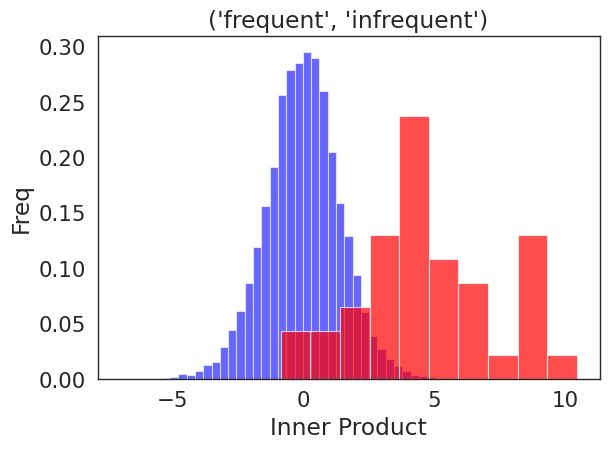

In [68]:
# this one is interesting = frequent/infrequent is about word frequency: 
# ['drink', 'beverage'],
# ['dry', 'arid'],
# ['end', 'terminate'],
# ['hot', 'sweltering']
# does this good separation imply that the model switches between different language styles (formal / informal / literature / casual) ?
k = ('frequent', 'infrequent')
fig1 = random_histogram(random_pairs_g, concept_g_orig[k], inner_prods_loo=causal_inner_prods_orig[k],  title=k)

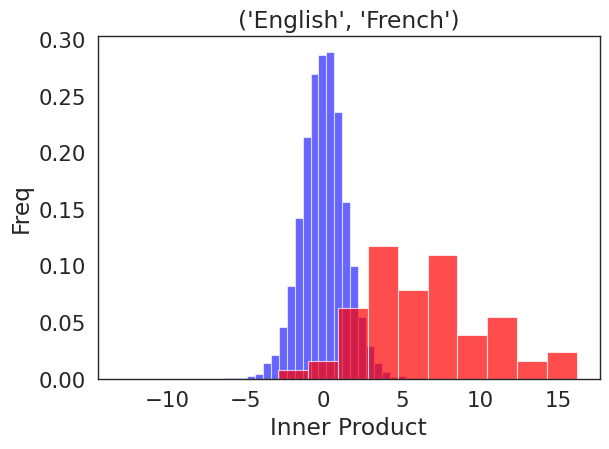

In [69]:
k = ('English', 'French')
fig2 = random_histogram(random_pairs_g, concept_g_orig[k], inner_prods_loo=causal_inner_prods_orig[k],  title=k)

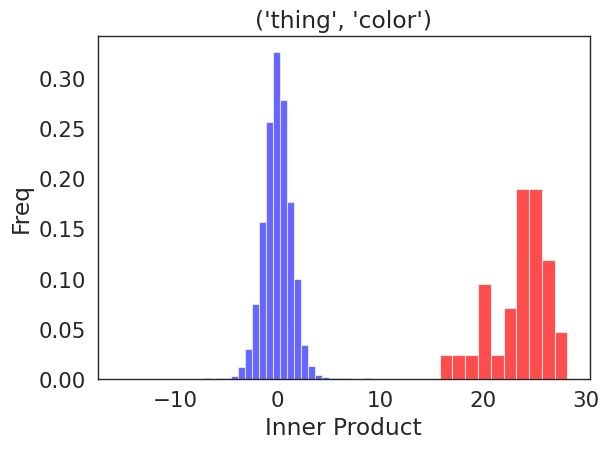

In [70]:
k = ('thing', 'color')
fig3 = random_histogram(random_pairs_g, concept_g_orig[k], inner_prods_loo=causal_inner_prods_orig[k],  title=k)
# nice?

In [72]:
concept_g_orig[k1].device

device(type='mps', index=0)

Text(0, 0.5, 'small_big')

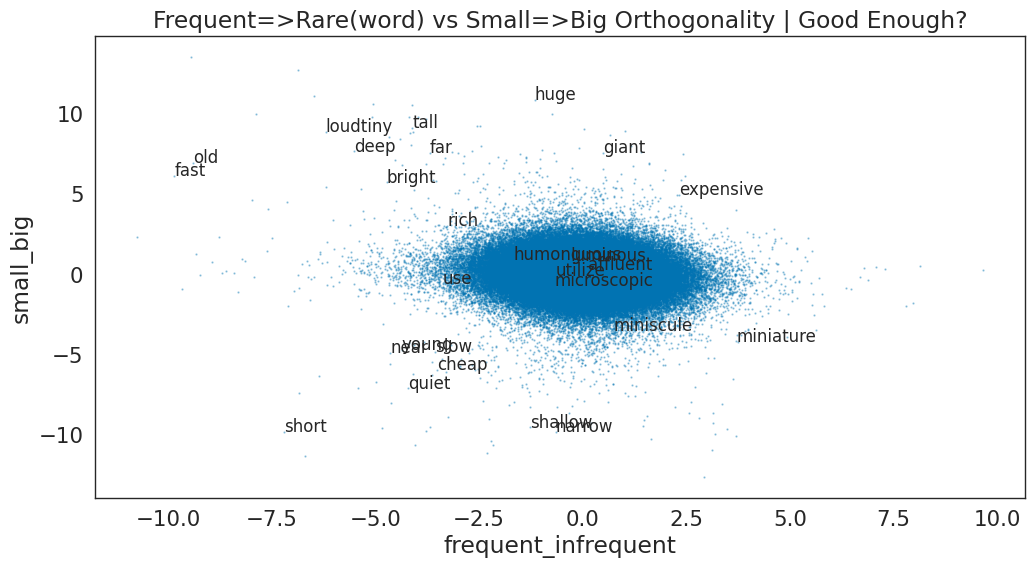

In [73]:
names = ['use', 'utilize', 'rich', 'affluent', 'bright', 'luminous', 'narrow', 'cheap', 'expensive',
        'young', 'old', 'near', 'far', 'shallow', 'deep',  'quiet', 'loud'
        'tiny', 'huge', 'slow', 'fast', 'short', 'tall', 'giant', 'miniature',
        'humonguous', 'miniscule', 'microscopic'
         ]
inds = [tokenizer.encode(word)[1] for word in names]


k1 = ('frequent','infrequent')
k2 = ('small', 'big')


a_g = (g @ concept_g_orig[k1]).cpu()
b_g = (g @ concept_g_orig[k2]).cpu()

fig, axs = plt.subplots(1, 1, figsize=(12,6))
plt.scatter(a_g.cpu(), b_g.cpu(), alpha = 0.3, s = 0.8)
for _, label in enumerate(names):
        axs.text(a_g[inds[_]], b_g[inds[_]], label, fontsize = 12)
plt.title('Frequent=>Rare(word) vs Small=>Big Orthogonality | Good Enough?')
plt.xlabel('_'.join(k1))
plt.ylabel('_'.join(k2))

# rarest words are often not so rare but rather just similar to what was types as "rare" in the training set (!)
# top_rarest_words = a_g.argsort()[-100:]
# tokenizer.convert_ids_to_tokens(top_rarest_words)

Text(0.5, 1.0, 'Male=>Female vs Eng=>French Orthogonality | Good Enough?')

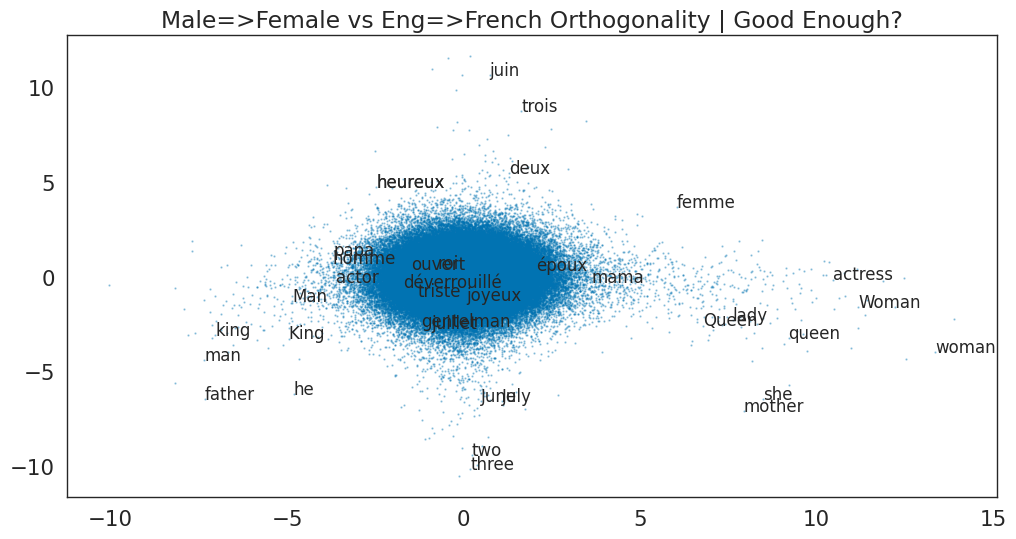

In [74]:
names = ["man", "woman", "king", "queen", "King", "Queen", "roi", "homme", "femme", "mama", "papa", "époux", 
        "actor", "actress", "Man", "Woman", "he", "she", "mother", "father", "lady", "gentelman",
        "deux", "two", "trois", "three", "July", "juillet", "June", "juin", 
        'heureux', 'joyeux', 'heureux', 'triste', 'ouvert', 'déverrouillé',]
inds = [tokenizer.encode(word)[1] for word in names]


k1 = ('male', 'female')
k2 = ('English', 'French')

a_g = (g @ concept_g_orig[k1]).cpu()
b_g = (g @ concept_g_orig[k2]).cpu()

fig, axs = plt.subplots(1, 1, figsize=(12,6))
plt.scatter(a_g.cpu(), b_g.cpu(), alpha = 0.3, s = 0.8)
for _, label in enumerate(names):
        axs.text(a_g[inds[_]], b_g[inds[_]], label, fontsize = 12)
plt.title('Male=>Female vs Eng=>French Orthogonality | Good Enough?')

The plot is pretty much the same, just skewed a bit!


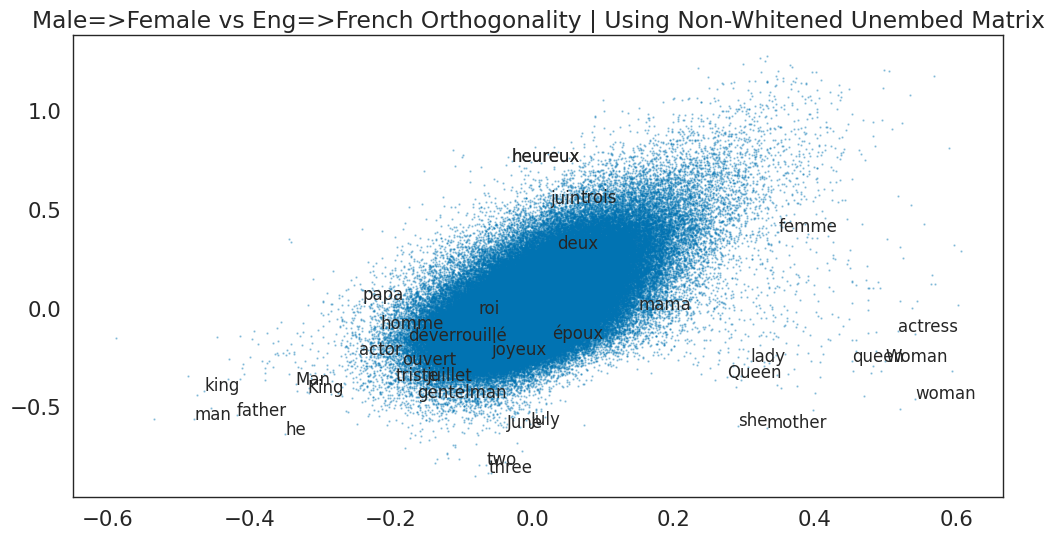

In [75]:
names = ["man", "woman", "king", "queen", "King", "Queen", "roi", "homme", "femme", "mama", "papa", "époux", 
        "actor", "actress", "Man", "Woman", "he", "she", "mother", "father", "lady", "gentelman",
        "deux", "two", "trois", "three", "July", "juillet", "June", "juin", 
        'heureux', 'joyeux', 'heureux', 'triste', 'ouvert', 'déverrouillé',]
inds = [tokenizer.encode(word)[1] for word in names]


k1 = ('male', 'female')
k2 = ('English', 'French')

a_g = (centered_unembed @ concept_g_orig[k1].cpu())
b_g = (centered_unembed @ concept_g_orig[k2].cpu())

fig, axs = plt.subplots(1, 1, figsize=(12,6))
plt.scatter(a_g.cpu(), b_g.cpu(), alpha = 0.3, s = 0.8)
for _, label in enumerate(names):
        axs.text(a_g[inds[_]], b_g[inds[_]], label, fontsize = 12)
plt.title('Male=>Female vs Eng=>French Orthogonality | Using Non-Whitened Unembed Matrix')
print('The plot is pretty much the same, just skewed a bit!')

In [33]:
del model

In [40]:
# Gemma with RotatE is hard to refactor!
model = HookedTransformer.from_pretrained(
    "google/gemma-2b",
    center_unembed=True,
    center_writing_weights=True,
    # fold_ln=True,
    # refactor_factored_attn_matrices=True,
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model google/gemma-2b into HookedTransformer


In [41]:
pre_logits = None

def capture_activations(module, input, output):
    global pre_logits
    pre_logits = output

hook_handle = model.ln_final.register_forward_hook(capture_activations)

model.tokenizer.padding_side = 'left'
tokens = model.to_tokens(concepts, prepend_bos=True)
model(tokens)

pre_logits_f = pre_logits[:, -1, :]
hook_handle.remove()

In [42]:
# I thought the hook of `ln_final` would give us already normalized vectors???
pre_logits_f.sum(dim=1)

tensor([109.6045, 103.8793,  78.3073,  52.9044,  59.8572, 117.0145,  90.2727,
         81.7069, 100.5760,  52.5828], device='mps:0')

In [77]:
cos_sim = (stacked_concept_vecs / stacked_concept_vecs.norm(dim=1, keepdim=True)) @ (pre_logits_f  / pre_logits_f.norm(dim=1, keepdim=True)).T

In [78]:
df = pd.DataFrame(cos_sim.cpu())
df.columns = concepts
df.index = ["_".join(k) for k in concept_g_orig.keys()]

In [79]:
df.idxmax()

gender          thing_color
translation     thing_color
size             thing_part
vertical        thing_color
frequency       thing_color
color           thing_color
inclusion       thing_color
plurality       thing_color
comparative    obj_material
superlative       small_big
dtype: object

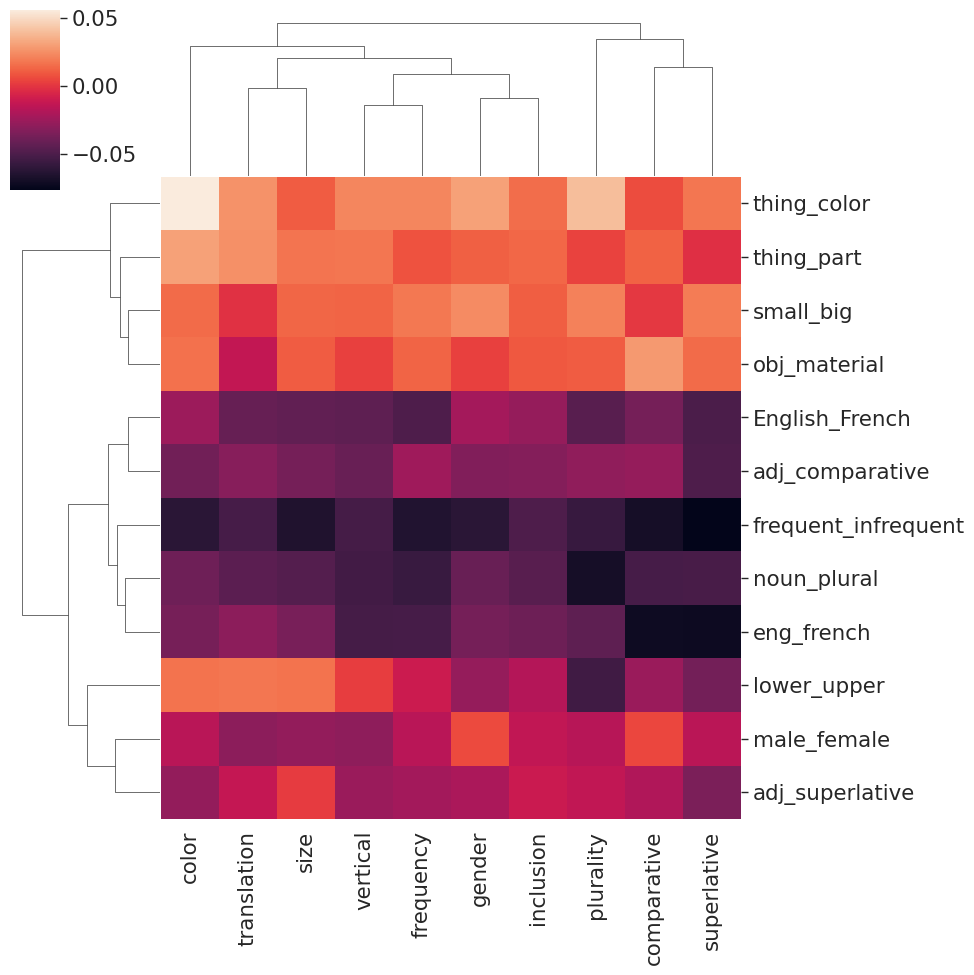

In [80]:
# actually lower-upper is about Uppercase not position
# and frequent-infrequent is about word frequency, not temporal frequency!
sns.clustermap(df)

In [81]:
# hook function to capture the output before right unembedding
def capture_activations(module, input, output):
        global pre_logits
        pre_logits = output

### Control by adding the Concept Vector to pre-logits

In [82]:
# Note that we have removed "training" data from the "test" set that originally was 102 words
# english_french_pairs = [tp for tp in english_french_pairs if tp[0] not in [w[0].lower() for w in all_words_pairs[('English', 'French')]]]
english_french_test = counterfact_word_pairs_store['test']['eng_french']
english_french_test[:5]

[['earth', 'terre'],
 ['dew', 'rosée'],
 ['fog', 'brouillard'],
 ['flint', 'silex'],
 ['wood', 'bois']]

In [87]:
from geomechinterp.logit_diff_utils import get_rank, compute_rank_difference
from geomechinterp.steering import generate_prompt_binary, compare_concept_steering

generate_prompt_binary(english_french_test[6])

('belt =', 'ceinture')

In [84]:
txt = 'Transantlantic Railway System'
prompt = 'Transantlantic'
answer = ' Railway System'
assert prompt+answer == txt

logits_txt = model(txt)
logits_prompt = model(prompt)

torch.allclose(logits_txt[:,:5, :], logits_prompt)
torch.allclose(logits_txt[:, logits_prompt.shape[1]-1, :], logits_prompt[:, -1, :])

True

In [85]:
model.ln_final

RMSNormPre(
  (hook_scale): HookPoint()
  (hook_normalized): HookPoint()
)

In [ ]:
k = ('English', 'French')
betas = [-5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 5, 8, 10, 20, 30, 100, 500]

train_word_pairs = all_words_pairs[k]
test_word_pairs = english_french_test
cocept_vector = concept_g_orig[k]

dff = compare_concept_steering(model, train_word_pairs, test_word_pairs, cocept_vector, betas)

In [527]:
# postive = rank decrease = "good"
dff[dff['train']].mean(axis=0)

-5.0              -26319.568359
-1.0               -3827.603516
-0.5               -1679.327637
0.0                    0.000000
0.5                 1233.224121
1.0                 2056.836182
1.5                 2535.241455
2.0                 2737.543213
5.0                 -119.491379
8.0                -7581.457031
10.0              -13364.232422
20.0              -34180.621094
30.0              -42875.414062
100.0             -53304.984375
500.0             -56368.179688
train                  1.000000
num_toks_answer        1.474138
dtype: float64

In [528]:
# for test we see even detrimental impact on the rank!
dff[~dff['train']].mean(axis=0)

-5.0               -6547.696777
-1.0                 418.212128
-0.5                 365.848480
0.0                   -0.015152
0.5                 -658.136353
1.0                -1585.439453
1.5                -2786.105957
2.0                -4245.575684
5.0               -17080.818359
8.0               -31928.621094
10.0              -41159.652344
20.0              -70497.625000
30.0              -80326.164062
100.0             -90043.851562
500.0             -92798.304688
train                  0.000000
num_toks_answer        1.696970
dtype: float64

In [496]:
# but this is simply due to 2+ token words over-represented in test compated to train
pd.crosstab(dff['train'], dff['num_toks_answer'])

num_toks_answer,1,2,3
train,,,
False,26,34,6
True,68,41,7


In [499]:
# restricting only to 1 tok words we get strong positive impact for test
dff[(~dff['train']) & (dff['num_toks_answer']==1)].mean(axis=0)

-5.0              -37632.269531
-1.0               -6410.384766
-0.5               -3061.576904
0.0                   -0.038462
0.5                 2811.961426
1.0                 5398.922852
1.5                 7746.346191
2.0                 9832.692383
5.0                16888.500000
8.0                18480.115234
10.0               18552.691406
20.0               16471.884766
30.0               14382.769531
100.0               7871.230957
500.0               4645.769043
train                  0.000000
num_toks_answer        1.000000
dtype: float64

In [500]:
# clearly two-token+  words screw us up quite a bit!
# the actual challenge would be to generalize to multi-token perplexity compute vs logit rank
# this can be done by considering cumulative perplexity but it is not clear how to average across multiple tokens
# just taking the mean is wrong because in-word tokens must have much higher perplexity than the first word
dff.groupby('num_toks_answer').agg(lambda x: round(sum(x)/len(x)))

,-5.0,-1.0,-0.5,0.0,0.5,1.0,1.5,2.0,5.0,8.0,10.0,20.0,30.0,100.0,500.0,train
num_toks_answer,,,,,,,,,,,,,,,,
1,-50976,-9217,-4357,0,3875,7303,10344,13042,23369,25735,25205,20777,17258,9676,6522,1
2,18657,5969,3146,0,-3432,-7120,-11044,-15140,-41117,-64786,-78485,-119527,-132795,-145297,-148132,1
3,-7129,182,226,0,-553,-1428,-2598,-4083,-19542,-42068,-57668,-123565,-149052,-164503,-166659,1


In [510]:
# we see saturation when growring Beta - probably due to normalization action on tokens
dff

,-5.0,-1.0,-0.5,0.0,0.5,1.0,1.5,2.0,5.0,8.0,10.0,20.0,30.0,100.0,500.0,train,num_toks_answer
April_avril,-145207.0,-41225.0,-19608.0,0.0,15775.0,28223.0,38259.0,46656.0,78737.0,83870.0,84201.0,84344.0,84338.0,84285.0,84236.0,True,1
August_août,-75501.0,-30874.0,-17365.0,0.0,21103.0,44452.0,66852.0,86196.0,145437.0,169435.0,172132.0,173435.0,173509.0,173546.0,173530.0,True,1
December_décembre,14754.0,4691.0,2466.0,0.0,-2595.0,-5175.0,-7739.0,-10348.0,-24525.0,-36344.0,-43524.0,-74268.0,-97854.0,-136778.0,-149696.0,True,2
February_février,13080.0,3945.0,2072.0,1.0,-2179.0,-4419.0,-6637.0,-8971.0,-21504.0,-32412.0,-38694.0,-65015.0,-83470.0,-116597.0,-128765.0,True,2
January_janvier,2359.0,918.0,508.0,0.0,-669.0,-1515.0,-2635.0,-4126.0,-22702.0,-44063.0,-55846.0,-101932.0,-144531.0,-214870.0,-230224.0,True,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hand_main,17604.0,6715.0,3698.0,0.0,-4444.0,-9663.0,-15656.0,-22530.0,-73259.0,-130992.0,-167106.0,-225582.0,-231638.0,-233770.0,-233901.0,False,1
cherry_cerise,59406.0,15334.0,7809.0,0.0,-8055.0,-16072.0,-24327.0,-32394.0,-75676.0,-108219.0,-123903.0,-147699.0,-152648.0,-155756.0,-155957.0,False,2
heart_cœur,1468.0,577.0,322.0,0.0,-401.0,-930.0,-1617.0,-2514.0,-17589.0,-48793.0,-71283.0,-185230.0,-231922.0,-251903.0,-252869.0,False,2
leaf_feuille,-80667.0,-8773.0,-3964.0,1.0,3393.0,6329.0,8927.0,11242.0,20277.0,23502.0,24160.0,23994.0,23256.0,21138.0,19878.0,False,1


In [576]:
px.box(dff[(~dff['train'])].sort_values(by='num_toks_answer')[[1.0, 1.5, 2.0, 5.0, 8.0, 10.0]].T, title='positive rank difference, English -> French, test set word pairs') # 1.0, 1.5, 2.0, 5.0, 8.0, 10 betas

In [573]:
# soil - sol are probably too similar
# wind - vent ?
# hand - main ? 
# schoold - ecole related to apostrophe?
px.box(dff[(~dff['train']) & (dff['num_toks_answer']==1)][[1.0, 1.5, 2.0, 5.0, 8.0,	10.0]].T, title='positive rank difference, English -> French, test set word pairs') # 1.0, 1.5, 2.0, 5.0, 8.0, 10 betas

In [523]:
dff2 = dff[dff['num_toks_answer']==1]
px.box(dff2 / dff2.abs().max(axis=0), color='train')

In [95]:
object_color_test = counterfact_word_pairs_store['test']['obj_color']
object_color_test[:5]

# object_color_tests = [tp for tp in object_color_test if tp[0] not in [w[0].lower() for w in all_words_pairs[('thing', 'color')]]]

[['sky', 'blue'],
 ['coal', 'black'],
 ['snow', 'white'],
 ['carrot', 'orange'],
 ['cherry', 'red']]

In [98]:
from geomechinterp.steering import compare_concept_steering

k = ('thing', 'color')
train_word_pairs = all_words_pairs[k]
test_word_pairs = object_color_test
cocept_vector = concept_g_orig[k]

dff = compare_concept_steering(model, train_word_pairs, test_word_pairs, cocept_vector, betas)

 10%|█         | 5/50 [00:18<02:35,  3.46s/it]

In [552]:
dff.groupby('num_toks_answer').agg(lambda x: round(sum(x)/len(x)))

,-5.0,-1.0,-0.5,0.0,0.5,1.0,1.5,2.0,5.0,8.0,10.0,20.0,30.0,100.0,500.0,train
num_toks_answer,,,,,,,,,,,,,,,,
1,-219909,-34676,-14185,0,8833,13926,16664,18073,19387,19415,19417,19418,19419,19419,19420,1
2,-210759,-28486,-11496,0,7044,11037,13112,14135,15050,15071,15072,15074,15074,15075,15075,1
3,-231239,-43172,-17185,0,10187,15596,18228,19335,20100,20109,20109,20112,20113,20113,20113,1


In [554]:
pd.crosstab(dff['train'], dff['num_toks_answer'])

num_toks_answer,1,2,3
train,,,
False,16,3,0
True,34,15,1


In [563]:
num_toks_eng = [model.to_tokens(w[0], prepend_bos=False).shape[1] for w in (all_words_pairs[('English', 'French')] + english_french_test)]
num_toks_fr = [model.to_tokens(w[1], prepend_bos=False).shape[1] for w in (all_words_pairs[('English', 'French')] + english_french_test)]

In [564]:
pd.crosstab(num_toks_eng + num_toks_fr, ['eng']*len(num_toks_eng) + ['fr']*len(num_toks_fr))

col_0,eng,fr
row_0,,
1,167,95
2,13,75
3,2,12


In [577]:
k = ('English', 'French')
betas = [-5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 5, 8, 10, 20, 30, 100, 500]

train_word_pairs = all_words_pairs[k]
test_word_pairs = english_french_test
cocept_vector = concept_g_orig[k]

train_word_pairs = [tp[::-1] for tp in train_word_pairs]
test_word_pairs = [tp[::-1] for tp in test_word_pairs]
 
dff = compare_concept_steering(train_word_pairs, test_word_pairs, -cocept_vector, betas) # dont forget minus for concept vector

100%|██████████| 66/66 [00:12<00:00,  5.22it/s]


In [578]:
# and we get much better results than for english -> french!
dff.groupby('num_toks_answer').agg(lambda x: round(sum(x)/len(x)))

,-5.0,-1.0,-0.5,0.0,0.5,1.0,1.5,2.0,5.0,8.0,10.0,20.0,30.0,100.0,500.0,train
num_toks_answer,,,,,,,,,,,,,,,,
1,-78419,-9388,-4272,0,3520,6381,8692,10539,16009,17540,17924,18254,18078,16473,15319,1
2,-46795,-6192,-2880,0,2472,4581,6365,7866,12910,14376,14511,12660,10688,5065,1753,1
3,-35636,-4338,-2031,0,1803,3378,4698,5839,9760,11126,11430,9945,6579,-3664,-8656,1


In [580]:
px.box(dff[(~dff['train'])].sort_values(by='num_toks_answer')[[1.0, 1.5, 2.0, 5.0, 8.0,	10.0]].T, title='positive rank difference, French -> English, test set word pairs') # 1.0, 1.5, 2.0, 5.0, 8.0, 10 betas

In [73]:
objects_material_train = counterfact_word_pairs_store['train']['obj_material']
objects_material_test = counterfact_word_pairs_store['test']['obj_material']
objects_material_train[:5]

[['table', 'wood'],
 ['bottle', 'glass'],
 ['knife', 'steel'],
 ['shirt', 'cotton'],
 ['window', 'glass']]

In [596]:
_, concept_material, *_ = generate_concept_direction(unembed=unembedding_matrix, rot_unembed=g, words_pairs=objects_material_train)

In [598]:
k = ('Object', 'Material')
betas = [-5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 5, 8, 10, 20, 30, 100, 500]

dff = compare_concept_steering(objects_material_train, objects_material_test, concept_material, betas) # dont forget minus for concept vector

100%|██████████| 15/15 [00:02<00:00,  5.08it/s]


In [599]:
# and we get much better results than for english -> french!
dff.groupby('num_toks_answer').agg(lambda x: round(sum(x)/len(x)))

,-5.0,-1.0,-0.5,0.0,0.5,1.0,1.5,2.0,5.0,8.0,10.0,20.0,30.0,100.0,500.0,train
num_toks_answer,,,,,,,,,,,,,,,,
1,-139701,-33828,-16041,0,13740,25047,34027,41033,59580,63670,64558,65639,65808,65805,65708,1
2,-86033,-19196,-9327,0,8463,15725,21703,26479,38462,39559,39153,35863,33120,24705,20636,1
3,-114,4,-6,0,4,-8,-34,-56,-247,-639,-1003,-4207,-9982,-65100,-122744,1


In [600]:
pd.crosstab(dff['train'], dff['num_toks_answer'])

num_toks_answer,1,2,3
train,,,
False,7,8,0
True,63,25,1


In [610]:
dff

,-5.0,-1.0,-0.5,0.0,0.5,1.0,1.5,2.0,5.0,8.0,10.0,20.0,30.0,100.0,500.0,train,num_toks_answer
table_wood,-140336.0,-66251.0,-35590.0,0.0,34320.0,61166.0,80206.0,92976.0,112341.0,112696.0,112703.0,112705.0,112705.0,112705.0,112705.0,True,1
bottle_glass,-122313.0,-11194.0,-5068.0,0.0,4055.0,7150.0,9535.0,11255.0,14744.0,14984.0,15004.0,15010.0,15009.0,15011.0,15012.0,True,1
knife_steel,-118320.0,-45666.0,-24359.0,0.0,24636.0,47755.0,67378.0,83224.0,125071.0,129622.0,129790.0,129830.0,129833.0,129838.0,129840.0,True,1
shirt_cotton,-106160.0,-26396.0,-13179.0,0.0,12673.0,24499.0,35378.0,45273.0,83264.0,97539.0,100709.0,102578.0,102623.0,102638.0,102641.0,True,1
window_glass,-125990.0,-34926.0,-17368.0,0.0,16576.0,31748.0,44677.0,55868.0,91177.0,98864.0,99550.0,99757.0,99762.0,99768.0,99769.0,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
towel_cotton,-115520.0,-17568.0,-8220.0,0.0,7254.0,13489.0,18894.0,23454.0,39179.0,43462.0,44147.0,44558.0,44566.0,44568.0,44567.0,False,2
notebook_paper,-113501.0,-17356.0,-8161.0,0.0,7163.0,13350.0,18669.0,23275.0,39750.0,45111.0,46095.0,46648.0,46650.0,46644.0,46641.0,False,1
chest_wood,-213401.0,-50545.0,-20941.0,0.0,14312.0,23771.0,29457.0,32583.0,35385.0,35406.0,35407.0,35409.0,35409.0,35409.0,35409.0,False,1
curtain_fabric,-22296.0,-3367.0,-1629.0,0.0,1548.0,2900.0,4228.0,5520.0,11156.0,14491.0,15950.0,18423.0,18747.0,18522.0,17921.0,False,2


In [601]:
# It is very surprising how well it works given that 
px.box(dff[(~dff['train'])].sort_values(by='num_toks_answer')[[1.0, 1.5, 2.0, 5.0, 8.0,	10.0]].T, title='positive rank difference, Object -> Material, test set word pairs')

In [692]:
betas = [0,1,2,3,4,5,6,7,8,9,10,15,20,30,50,100]
all_stats = []
for word_pair in objects_material_test:
    for beta in betas:
        res = compute_rank_difference(word_pair, concept_material, connector='=', betas=[beta], print_all=False, return_stats=True)
        res['beta'] = beta
        res['word_pair'] = "_".join(word_pair)
        all_stats.append(res)

In [691]:
compute_rank_difference(('curtain', 'fabric'), concept_material, connector='=', betas=[10], print_all=False, return_stats=True)

{'original_rank': 1065,
 'perturbed_rank': 187,
 'original_output': 'input',
 'perturbed_output': 'metal'}

In [693]:
df = pd.DataFrame(all_stats)

In [720]:
px.line(df[df['beta']<40], x='beta', y='perturbed_rank', color='word_pair', markers='<>', title='Answer Rank Decrease (1=best) after adding `beta*material_concept_vec` to pre-logits')

In [724]:
from collections import Counter
# badly performing materials are not present in the "train set" 
CC = Counter([w[1] for w in objects_material_train])
print(CC.get('feathers'))
print(CC.get('straw'))
print(CC.get('linen'))

print(CC.get('rubber'))
print(CC.get('concrete'))
print(CC.get('stainless steel'))

None
None
None
1
1
1


In [728]:
df['perturbed_output'].value_counts()

perturbed_output
wood        133
input        51
metal        25
0            13
int           7
function      5
1             5
require       1
Name: count, dtype: int64

In [719]:
px.line(df[(df['beta']<10)&(df['original_rank']<5000)], x='beta', y='perturbed_rank', color='word_pair', markers='<>', log_x=True, log_y=True, title='Answer Rank Decrease (1=best) after adding `beta*material_concept_vec` to pre-logits')

In [74]:
object_part_test = counterfact_word_pairs_store['test']['object_part']
object_part_test[:5]

[['lamp', 'shade'],
 ['boot', 'heel'],
 ['broom', 'handle'],
 ['book', 'page'],
 ['tree', 'branch']]

In [806]:
# lets try to run Thing -> Part forward vs reverse
k = ('thing', 'part')
betas = [-5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 5, 8, 10, 20, 30, 100, 500]

train_word_pairs = all_words_pairs[k]
test_word_pairs = object_part_test
cocept_vector = concept_g_orig[k]
 
dff = compare_concept_steering([], test_word_pairs, cocept_vector, betas) # dont forget minus for concept vector

100%|██████████| 24/24 [00:04<00:00,  5.26it/s]


In [809]:
beta = 5 # beta=5 is optimal in most cases 
object_to_part = dff[(~dff['train'])].sort_values(by='num_toks_answer')[beta].T

In [822]:
# train_word_pairs = [tp[::-1] for tp in all_words_pairs[k]]
# test_word_pairs = [tp[::-1] for tp in test_word_pairs]
 
dff = compare_concept_steering([], test_word_pairs, -cocept_vector, betas) # dont forget minus for concept vector

part_to_object = dff[(~dff['train'])].sort_values(by='num_toks_answer')[beta].T

100%|██████████| 24/24 [00:04<00:00,  5.14it/s]


In [825]:
df = pd.DataFrame(object_to_part)
df.columns = ['direct']
df['inverse'] = part_to_object.values
px.bar(df, barmode='group', title='Rank Decrease for Thing -> Part vs Part -> Thing')

In [778]:
dff2 = dff[dff['num_toks_answer']==1].iloc[:,3:]
px.box(dff2 / dff2.abs().max(axis=0), color='train', title='positive rank difference, Part -> Thing, Train pairs (blue) | Test pairs (red)')

### Going deeper into the model

In [949]:
list(concept_g_orig.keys())

[('male', 'female'),
 ('English', 'French'),
 ('small', 'big'),
 ('lower', 'upper'),
 ('frequent', 'infrequent'),
 ('thing', 'color'),
 ('thing', 'part'),
 ('noun', 'plural'),
 ('adj', 'comparative'),
 ('adj', 'superlative')]

In [984]:
# lets check incrementally "bigger" objects according to the "small-big" concept
# micro, mini, minor, small, average, broad, big, large, giant, huge, immense, gigantic, enormous, colossal, mammoth, 
k = ('small', 'big')
compute_rank_difference(counterfact_pair=('average', 'small'), concept_vector=concept_g_orig[k], betas=[-10], return_stats=True, connector=' or')

prompt: average or
expected answer: small
expected answer original logit: 2.349363327026367
expected answer original rank: 71463
top-1 pred orig:  mean
expected answer perturbed logit: 11.27486801147461
expected answer perturbed rank: 262
top-1 pred perturb:  small


{'original_rank': 71463,
 'perturbed_rank': 262,
 'original_output': ' mean',
 'perturbed_output': ' small'}

In [1036]:
def _find_beta_changes(df):
    df = df.sort_values(by='beta').reset_index(drop=True)
    changes = df['perturbed_output'].ne(df['perturbed_output'].shift()).astype(int)
    boundaries = df['beta'][changes == 1].tolist()
    return boundaries

def polynomial_space(start, stop, num, power=2.0):
    linear_space = np.linspace(0, 1, num)
    nonlinear_space = np.power(linear_space, power)
    return start + (stop - start) * nonlinear_space

In [1151]:
center_words = ['micro', 'mini', 'short', 'average', 'normal', 'enormous', 'Moon', 'Sun', 'house', 'mouse', 'pebble']
outputs = {}

# we scan pre-logit space with beta varying from -300 to +300 and starting from differen "center" words 
# this is for the concept_vectors allegedly describing size concept
for word in center_words:
    stats = compute_rank_difference(counterfact_pair=(word, 'small'), concept_vector=concept_g_orig[k], betas=polynomial_space(-200, 200, 1000), 
                                print_all=False, return_stats=True, connector=',')
    df = pd.DataFrame(stats)
    beta_bounds = _find_beta_changes(df)
    switching_words = df['perturbed_output'].unique()
    outputs[word] = {'beta_bounds':beta_bounds, 'switching_words':switching_words}

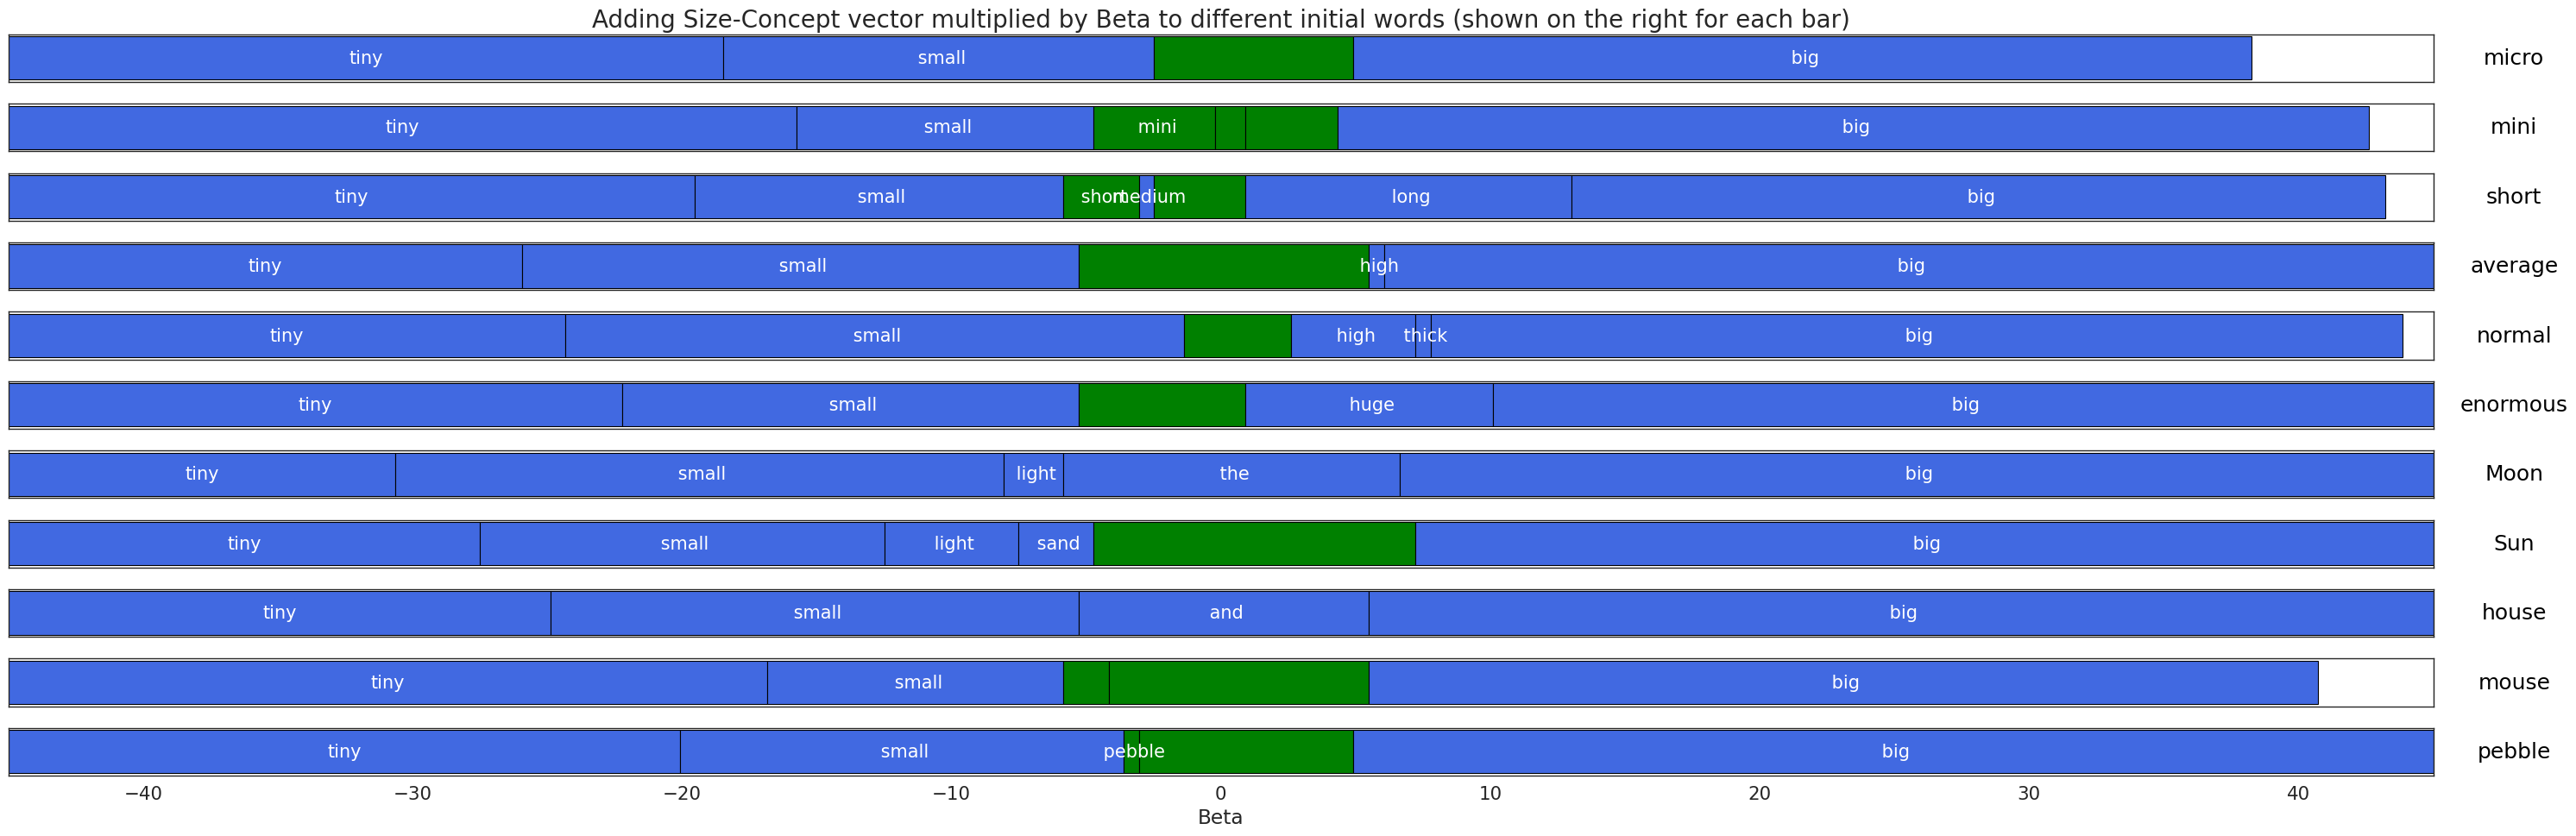

In [1153]:
from geomechinterp.plots import plot_word_change

plot_word_change([v['beta_bounds'] for v in outputs.values()], [v['switching_words'] for v in outputs.values()], len(center_words), labels=list(outputs.keys()))


In [1025]:
stats = compute_rank_difference(counterfact_pair=('Moon', 'small'), concept_vector=concept_g_orig[k], betas=np.linspace(-100, 100, 1000), 
                                print_all=False, return_stats=True, connector=' or')
pd.DataFrame(stats)['perturbed_output'].unique()

array(['tiny', ' Shallow', ' small', ' light', ' sun', ' Sun', ' big',
       'big'], dtype=object)

In [388]:
# example_prompt = "There is a fine line between stupid and... "
utils.test_prompt('Switch the gender of the word: actor:actress,  wife:', 'husband', model, prepend_bos=True)

Tokenized prompt: ['<bos>', 'Switch', ' the', ' gender', ' of', ' the', ' word', ':', ' actor', ':', 'actress', ',', '  ', 'wife', ':']
Tokenized answer: [' husband']


Performance on answer token:
Rank: 1        Logit: 18.53 Prob: 13.32% Token: | husband|

Top 0th token. Logit: 19.93 Prob: 53.73% Token: |husband|
Top 1th token. Logit: 18.53 Prob: 13.32% Token: | husband|
Top 2th token. Logit: 18.11 Prob:  8.73% Token: |wife|
Top 3th token. Logit: 16.64 Prob:  2.01% Token: | ________|
Top 4th token. Logit: 16.32 Prob:  1.46% Token: |<strong>|
Top 5th token. Logit: 16.29 Prob:  1.41% Token: | wife|
Top 6th token. Logit: 16.27 Prob:  1.38% Token: | |
Top 7th token. Logit: 16.13 Prob:  1.20% Token: |______|
Top 8th token. Logit: 15.79 Prob:  0.85% Token: |____|
Top 9th token. Logit: 15.62 Prob:  0.72% Token: | ______|


Ranks of the answer tokens: [(' husband', 1)]

#### Going deeper into Transformer

In [ ]:
# original test
example_prompt = "There is a fine line between stupid and... "
example_answer = " clever"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<bos>', 'There', ' is', ' a', ' fine', ' line', ' between', ' stupid', ' and', '...', ' ']
Tokenized answer: [' clever']


Performance on answer token:
Rank: 10724    Logit:  7.53 Prob:  0.00% Token: | clever|

Top 0th token. Logit: 23.27 Prob: 52.74% Token: |<em>|
Top 1th token. Logit: 22.25 Prob: 19.12% Token: |<i>|
Top 2th token. Logit: 21.96 Prob: 14.29% Token: |<strong>|
Top 3th token. Logit: 21.04 Prob:  5.69% Token: |<b>|
Top 4th token. Logit: 20.39 Prob:  2.96% Token: |

|
Top 5th token. Logit: 19.13 Prob:  0.84% Token: |1|
Top 6th token. Logit: 18.99 Prob:  0.73% Token: |
|
Top 7th token. Logit: 18.67 Prob:  0.53% Token: |5|
Top 8th token. Logit: 18.62 Prob:  0.51% Token: |2|
Top 9th token. Logit: 18.56 Prob:  0.48% Token: |<u>|


Ranks of the answer tokens: [(' clever', 10724)]

1. Concepts are like Predicates in KG
2. When we add the Concept's Vector we do `Head -[dir]-> Tail`  transition, hence we call first words in counterfact pairs `h` and second words `t` and the transition vector is `v` 
3. `Hypothesis 1`: adding Concept's Vector `v` to the pre-logits vec should move us to a Tail-Like concepts, if from context `c` we anticipated `h` - as in Word2Vec 
4. `Hypothesis 2`: chaining counterfactual pairs [(w11, w12), ...] as a long list should make predicted wn2 in the last (wn1, wn2) aligned with Concept's Vector
5. `Hypothesis 3`: given a single word `h` in a counterfactual pair + the Concept's vector `v` we should be able to predict something similar to the second word
6. `Hypothesis 4`: given a collection of words `h1,h2,..,h_n` from one side of counterfactual pairs + the Concept's vector `v` we should be able to predict smth similar to the `mean` of their pairs `t`

In [1208]:
utils.test_prompt("A:(blue plastic ball), B:(red wood square), C:(green metal triangle), A is", 'blue', model, prepend_bos=True, print_details=True)

Tokenized prompt: ['<bos>', 'A', ':(', 'blue', ' plastic', ' ball', '),', ' B', ':(', 'red', ' wood', ' square', '),', ' C', ':(', 'green', ' metal', ' triangle', '),', ' A', ' is']
Tokenized answer: [' blue']


Performance on answer token:
Rank: 41       Logit: 15.69 Prob:  0.34% Token: | blue|

Top 0th token. Logit: 19.29 Prob: 12.28% Token: | the|
Top 1th token. Logit: 18.68 Prob:  6.65% Token: | a|
Top 2th token. Logit: 18.35 Prob:  4.78% Token: | in|
Top 3th token. Logit: 18.30 Prob:  4.55% Token: | connected|
Top 4th token. Logit: 18.13 Prob:  3.82% Token: | placed|
Top 5th token. Logit: 18.10 Prob:  3.74% Token: | on|
Top 6th token. Logit: 17.80 Prob:  2.76% Token: | heavier|
Top 7th token. Logit: 17.69 Prob:  2.48% Token: | |
Top 8th token. Logit: 17.64 Prob:  2.35% Token: | not|
Top 9th token. Logit: 17.28 Prob:  1.64% Token: | joined|


Ranks of the answer tokens: [(' blue', 41)]

In [1254]:
prompt_pair = ("A:(blue plastic ball), B:(red wood square), C:(green metal triangle), A is", 'plastic')
# does not seem to work that well:(
dff = compute_rank_difference(counterfact_pair=prompt_pair, concept_vector=concept_material, betas=[1,3,5,7,10,15, 50, 100], 
                                print_all=False, return_stats=True, connector='')
dff = pd.DataFrame(dff)

In [1269]:
prompt_pair = ("A:(blue plastic ball), B:(red wood square), C:(green plastic ball), D:(blue metal ball), E:(red paper square), F:(yellow wood triangle). I change C and get:", 'A')
# does not seem to work that well:(
dff = compute_rank_difference(counterfact_pair=prompt_pair, concept_vector=concept_g_orig[k], betas=[0.2,0.5,1,1.5,2,3,4,5,7,10], 
                                print_all=False, return_stats=True, connector='')
dff = pd.DataFrame(dff)
dff

,original_rank,perturbed_rank,original_output,perturbed_output,rank_diff,beta
0,42,45,E,E,-3,0.2
1,42,46,E,red,-4,0.5
2,42,53,E,red,-11,1.0
3,42,53,E,red,-11,1.5
4,42,58,E,red,-16,2.0
5,42,65,E,red,-23,3.0
6,42,73,E,red,-31,4.0
7,42,78,E,red,-36,5.0
8,42,94,E,red,-52,7.0
9,42,107,E,red,-65,10.0


In [1270]:
prompt_pair = ("A:(blue plastic ball), B:(red wood square), C:(green plastic ball), D:(blue metal ball). I change D and get:", 'A')
# does not seem to work that well:(
dff = compute_rank_difference(counterfact_pair=prompt_pair, concept_vector=concept_material, betas=[0.2,0.5,1,1.5,2,3,4,5,7,10], 
                                print_all=False, return_stats=True, connector='')
dff = pd.DataFrame(dff)
dff

,original_rank,perturbed_rank,original_output,perturbed_output,rank_diff,beta
0,19,19,A,A,0,0.2
1,19,19,A,A,0,0.5
2,19,18,A,A,1,1.0
3,19,18,A,A,1,1.5
4,19,17,A,A,2,2.0
5,19,17,A,A,2,3.0
6,19,19,A,A,0,4.0
7,19,22,A,A,-3,5.0
8,19,39,A,metal,-20,7.0
9,19,61,A,metal,-42,10.0
